In [118]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import ConcatDataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

In [119]:
totensor = transforms.Compose(
  [transforms.ToTensor()])

batch_size = 32

trainval_set = datasets.CIFAR10(root='./data', train=True, download=True, transform=totensor)
train_set, val_set = torch.utils.data.random_split(trainval_set, [int(0.8*len(trainval_set)), int(0.2*len(trainval_set))])

testset = datasets.CIFAR10(root='./data', train=False, download=True, transform=totensor)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


In [120]:
train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True, num_workers=2)
test_dataloader = torch.utils.data.DataLoader(testset, batch_size=batch_size, shuffle=False, num_workers=2)

In [121]:
print("First data point")
print(f"Shape: {train_set[0][0].size()}")
print(f"Tensor: {train_set[0][0]}")
print(f"Label: {train_set[0][1]}")

First data point
Shape: torch.Size([3, 32, 32])
Tensor: tensor([[[0.9137, 0.9020, 0.9020,  ..., 0.7765, 0.7647, 0.7529],
         [0.9216, 0.9098, 0.9020,  ..., 0.8039, 0.7922, 0.7843],
         [0.9529, 0.9373, 0.9137,  ..., 0.8353, 0.8275, 0.8196],
         ...,
         [0.5804, 0.5608, 0.5569,  ..., 0.7176, 0.7529, 0.7216],
         [0.6196, 0.6235, 0.5882,  ..., 0.4980, 0.6235, 0.6941],
         [0.5647, 0.5843, 0.5843,  ..., 0.3529, 0.3098, 0.4314]],

        [[1.0000, 1.0000, 1.0000,  ..., 0.9059, 0.8941, 0.8824],
         [1.0000, 0.9882, 0.9804,  ..., 0.9216, 0.9098, 0.8980],
         [1.0000, 0.9961, 0.9725,  ..., 0.9373, 0.9333, 0.9216],
         ...,
         [0.5176, 0.5020, 0.4980,  ..., 0.6706, 0.6980, 0.6667],
         [0.5608, 0.5647, 0.5294,  ..., 0.4667, 0.5882, 0.6510],
         [0.5059, 0.5255, 0.5255,  ..., 0.3608, 0.3098, 0.4235]],

        [[1.0000, 0.9961, 1.0000,  ..., 1.0000, 0.9922, 0.9922],
         [0.9961, 0.9843, 0.9765,  ..., 0.9882, 0.9882, 0.9882],
  

In [122]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda device


In [123]:
torch.zeros(1).cuda()

tensor([0.], device='cuda:0')

In [124]:
data_augmentation = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-5, 5)),
    transforms.ColorJitter(brightness=(0.6,1.4), contrast=(0.6,1.4), saturation=(0.6,1.4), hue=(-0.1,0.1))
])

In [125]:
normalize = transforms.Compose([    
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [126]:
inv_normalize = transforms.Normalize(
    mean=[-0.5/0.5, -0.5/0.5, -0.5/0.5],
    std=[1/0.5, 1/0.5, 1/0.5]
)

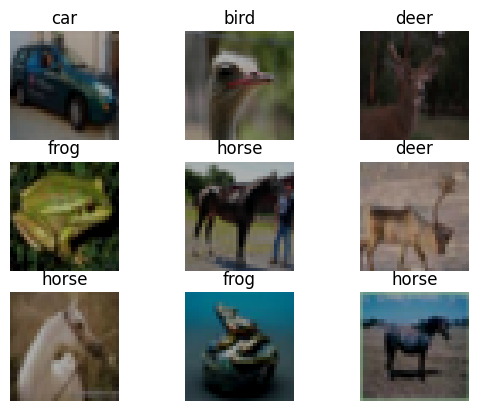

In [127]:
images, labels = next(iter(train_dataloader))
images = data_augmentation(images)
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[labels[i]])
  plt.axis("off")

### Neural Network

In [128]:
class NNmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.normalize = normalize
    self.flatten = nn.Flatten()
    self.linear_relu = nn.Sequential(
        nn.Linear(3*32*32, 500),
        nn.ReLU(),
        nn.Linear(500, 500),
        nn.ReLU(),
        nn.Linear(500, 10)
    )
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.normalize(x)
    x = self.flatten(x)
    return self.linear_relu(x)


In [129]:
nn_model = NNmodel().to(device)
print(nn_model)

NNmodel(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu): Sequential(
    (0): Linear(in_features=3072, out_features=500, bias=True)
    (1): ReLU()
    (2): Linear(in_features=500, out_features=500, bias=True)
    (3): ReLU()
    (4): Linear(in_features=500, out_features=10, bias=True)
  )
)


In [133]:
learning_rate = 1e-4
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(nn_model.parameters(), lr=learning_rate)

In [134]:
def train_loop(dataloader, model, loss_fn, optimizer):
  total_loss, correct = 0, 0
  model.train()
  for batch, (X, y) in enumerate(dataloader):
    optimizer.zero_grad()
    X, y = X.cuda(), y.cuda()
    pred = model(X)
    loss = loss_fn(pred, y)
    total_loss += loss.item()
    correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    loss.backward()
    optimizer.step()
    
    if batch%500 == 499:
      print(f"loss: {loss:.7f}  [{batch+1:5d}/{len(dataloader):5d}]")

  accuracy = correct/float(len(dataloader.dataset))
  avg_loss = total_loss/float(len(dataloader.dataset))
  print("---Train---")
  print(f"Accuracy: {accuracy}")
  print(f"Average loss: {avg_loss}")
  return avg_loss, accuracy

def val_loop(dataloader, model, loss_fn):
  total_loss, correct = 0, 0
  model.eval()
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.cuda(), y.cuda()
      pred = model(X)
      loss = loss_fn(pred, y)
      total_loss += loss.item()
      correct += (pred.argmax(1) == y).type(torch.float).sum().item()
      
    accuracy = correct/float(len(dataloader.dataset))
    avg_loss = total_loss/float(len(dataloader.dataset))
    print("---Validation---")
    print(f"Accuracy: {accuracy}")
    print(f"Average loss: {avg_loss}")
  return avg_loss, accuracy



In [135]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, nn_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = val_loop(test_dataloader, nn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(test_loss_output)
  val_accuracy.append(test_acc_output)

Epoch 1
loss: 1.7602071  [  500/ 1250]
loss: 1.6354884  [ 1000/ 1250]
---Train---
Accuracy: 0.429625
Average loss: 0.05075177370905876
---Validation---
Accuracy: 0.4543
Average loss: 0.0489241171002388
Epoch 2
loss: 1.6442270  [  500/ 1250]
loss: 1.9168574  [ 1000/ 1250]
---Train---
Accuracy: 0.461
Average loss: 0.0483138248950243
---Validation---
Accuracy: 0.4688
Average loss: 0.04750447784662247
Epoch 3
loss: 1.3452647  [  500/ 1250]
loss: 1.2829469  [ 1000/ 1250]
---Train---
Accuracy: 0.482925
Average loss: 0.046321726642549035
---Validation---
Accuracy: 0.4734
Average loss: 0.047327411085367206
Epoch 4
loss: 1.5798202  [  500/ 1250]
loss: 1.6591710  [ 1000/ 1250]
---Train---
Accuracy: 0.49495
Average loss: 0.04515136051177979
---Validation---
Accuracy: 0.4977
Average loss: 0.04516882446408272
Epoch 5
loss: 1.1255580  [  500/ 1250]
loss: 1.5413526  [ 1000/ 1250]
---Train---
Accuracy: 0.50815
Average loss: 0.043954438704252245
---Validation---
Accuracy: 0.5073
Average loss: 0.0446730

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024050C82C20>
Traceback (most recent call last):
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024050C82C20>
Traceback (most recent call last):
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_w

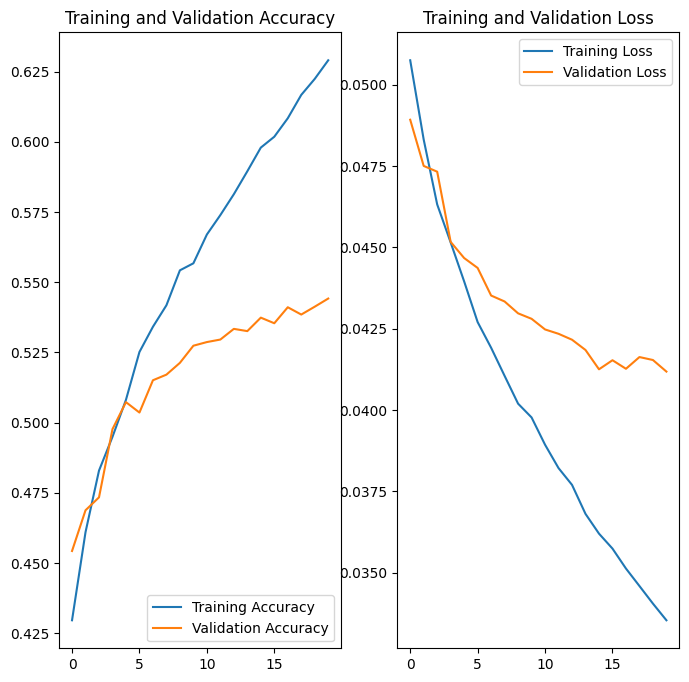

In [136]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [138]:
def test_loop(dataloader, model, loss_fn):
    total_loss, correct = 0, 0
    model.eval()

    for X, y in dataloader:
        X, y = X.cuda(), y.cuda()
        with torch.no_grad():
            pred = model(X)
            loss = loss_fn(pred, y)
            total_loss += loss.item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
            
    accuracy = correct/float(len(dataloader.dataset))

    print("---Test---")
    print(f"Accuracy: {accuracy}")
    print(f"Total loss: {total_loss}")

    return total_loss, accuracy

In [139]:
test_loop(test_dataloader, nn_model, loss_fn)

---Test---
Accuracy: 0.545
Total loss: 415.5382736325264


(415.5382736325264, 0.545)

In [140]:
images, labels = next(iter(test_dataloader))

outputs = nn_model(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 8, 1, 8, 4, 6, 2, 6, 4, 1, 0, 1, 7, 7, 9, 8, 2, 7, 8, 6, 4, 0, 2, 9,
        4, 4, 4, 2, 9, 6, 6, 4], device='cuda:0')


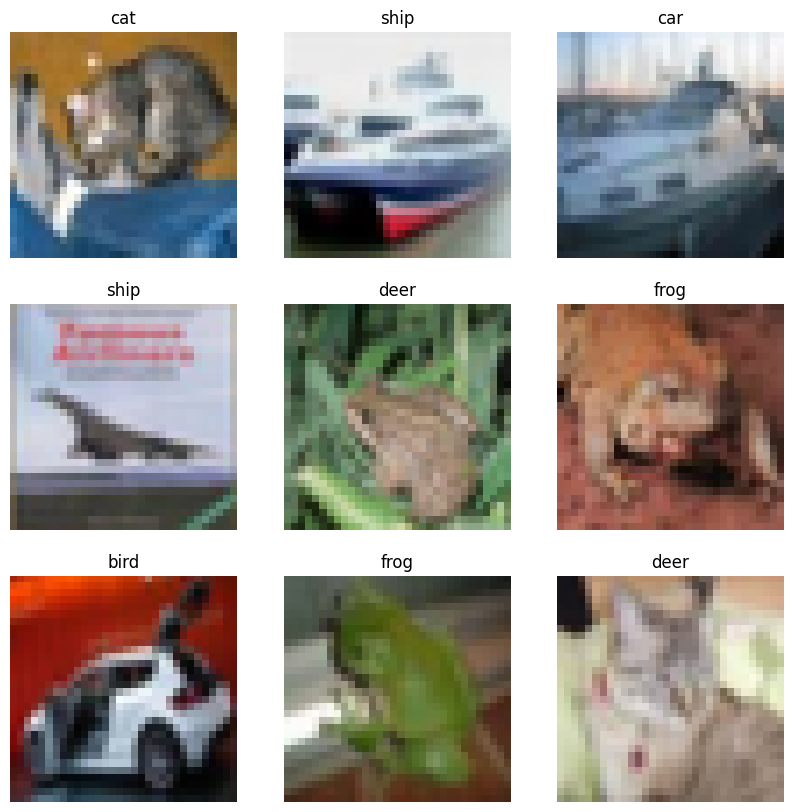

In [141]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

### CNN

In [142]:
class CNNmodel(nn.Module):
  def __init__(self):
    super().__init__()
    self.data_augmentation = data_augmentation
    self.normalize = normalize
    self.network = nn.Sequential(
      #3x32x32 -> 6x32x32
      nn.Conv2d(3, 6, 3, padding=1),
      nn.ReLU(),
      #6x32x32 -> 6x16x16
      nn.MaxPool2d(2, 2),
      #6x16x16 -> 12x16x16
      nn.Conv2d(6, 12, 3, padding=1),
      nn.ReLU(),
      #12x16x16 -> 12x8x8
      nn.MaxPool2d(2, 2),
      nn.Dropout(0.2),
      #Flatten all except batch
      #12x8x8 -> 768
      nn.Flatten(),
      nn.Linear(768, 150),
      nn.ReLU(),
      nn.Linear(150, 80),
      nn.ReLU(),
      nn.Linear(80, 10)
      )
  def forward(self, x):
    x = self.data_augmentation(x)
    x = self.normalize(x)
    return self.network(x)


In [158]:
cnn_model = CNNmodel().to(device)
print(cnn_model)

CNNmodel(
  (network): Sequential(
    (0): Conv2d(3, 6, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(6, 12, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Dropout(p=0.2, inplace=False)
    (7): Flatten(start_dim=1, end_dim=-1)
    (8): Linear(in_features=768, out_features=150, bias=True)
    (9): ReLU()
    (10): Linear(in_features=150, out_features=80, bias=True)
    (11): ReLU()
    (12): Linear(in_features=80, out_features=10, bias=True)
  )
)


In [159]:
from torchsummary import summary
summary(cnn_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 32, 32]             168
              ReLU-2            [-1, 6, 32, 32]               0
         MaxPool2d-3            [-1, 6, 16, 16]               0
            Conv2d-4           [-1, 12, 16, 16]             660
              ReLU-5           [-1, 12, 16, 16]               0
         MaxPool2d-6             [-1, 12, 8, 8]               0
           Dropout-7             [-1, 12, 8, 8]               0
           Flatten-8                  [-1, 768]               0
            Linear-9                  [-1, 150]         115,350
             ReLU-10                  [-1, 150]               0
           Linear-11                   [-1, 80]          12,080
             ReLU-12                   [-1, 80]               0
           Linear-13                   [-1, 10]             810
Total params: 129,068
Trainable params:

In [160]:
learning_rate = 1e-3
epochs = 20

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(cnn_model.parameters(), lr=learning_rate)

In [161]:
train_accuracy = []
val_accuracy = []
train_loss = []
val_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = val_loop(test_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(test_loss_output)
  val_accuracy.append(test_acc_output)

Epoch 1
loss: 1.7979860  [  500/ 1250]
loss: 1.5501184  [ 1000/ 1250]
---Train---
Accuracy: 0.3596
Average loss: 0.05499233253598213
---Validation---
Accuracy: 0.433
Average loss: 0.0488534677863121
Epoch 2
loss: 1.4607141  [  500/ 1250]
loss: 1.5254290  [ 1000/ 1250]
---Train---
Accuracy: 0.469
Average loss: 0.0462817460924387
---Validation---
Accuracy: 0.5066
Average loss: 0.0433723570227623
Epoch 3
loss: 1.4491189  [  500/ 1250]
loss: 1.7686700  [ 1000/ 1250]
---Train---
Accuracy: 0.51635
Average loss: 0.04254179752767086
---Validation---
Accuracy: 0.5465
Average loss: 0.03993316577672958
Epoch 4
loss: 1.2800487  [  500/ 1250]
loss: 1.2726167  [ 1000/ 1250]
---Train---
Accuracy: 0.546325
Average loss: 0.04001360402703285
---Validation---
Accuracy: 0.5734
Average loss: 0.0380651760995388
Epoch 5
loss: 1.4034910  [  500/ 1250]
loss: 1.4544698  [ 1000/ 1250]
---Train---
Accuracy: 0.57125
Average loss: 0.03814566997438669
---Validation---
Accuracy: 0.5897
Average loss: 0.036256466859579

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x0000024050C82C20>
Traceback (most recent call last):
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1478, in __del__
    self._shutdown_workers()
  File "c:\Users\waiho\Documents\Python_venv\AI_ML_env\lib\site-packages\torch\utils\data\dataloader.py", line 1436, in _shutdown_workers
    if self._persistent_workers or self._workers_status[worker_id]:
AttributeError: '_MultiProcessingDataLoaderIter' object has no attribute '_workers_status'


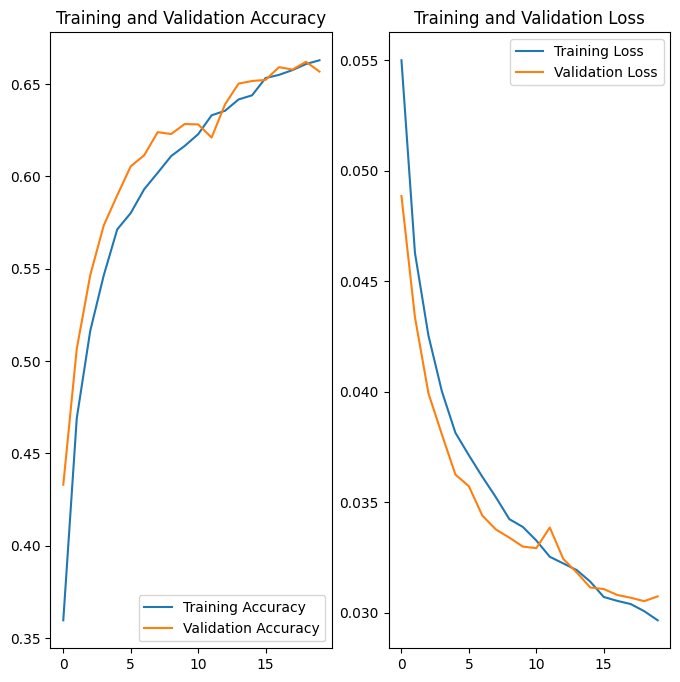

In [162]:
epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [163]:
#train for 10 more epochs

for i in range(10):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, cnn_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = val_loop(test_dataloader, cnn_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  val_loss.append(test_loss_output)
  val_accuracy.append(test_acc_output)

Epoch 1
loss: 0.9807642  [  500/ 1250]
loss: 0.9583209  [ 1000/ 1250]
---Train---
Accuracy: 0.6706
Average loss: 0.029347720321267843
---Validation---
Accuracy: 0.6649
Average loss: 0.03024826183617115
Epoch 2
loss: 0.8204263  [  500/ 1250]
loss: 0.9056966  [ 1000/ 1250]
---Train---
Accuracy: 0.67
Average loss: 0.0292029096275568
---Validation---
Accuracy: 0.6595
Average loss: 0.030812836769223213
Epoch 3
loss: 0.9758515  [  500/ 1250]
loss: 1.0039935  [ 1000/ 1250]
---Train---
Accuracy: 0.6722
Average loss: 0.028879132384806872
---Validation---
Accuracy: 0.6658
Average loss: 0.0301882075548172
Epoch 4
loss: 0.8719649  [  500/ 1250]
loss: 1.2403505  [ 1000/ 1250]
---Train---
Accuracy: 0.675675
Average loss: 0.028730903843790293
---Validation---
Accuracy: 0.6654
Average loss: 0.0302189488530159
Epoch 5
loss: 0.8769432  [  500/ 1250]
loss: 0.5349538  [ 1000/ 1250]
---Train---
Accuracy: 0.680175
Average loss: 0.028506489364802837
---Validation---
Accuracy: 0.6613
Average loss: 0.030412933

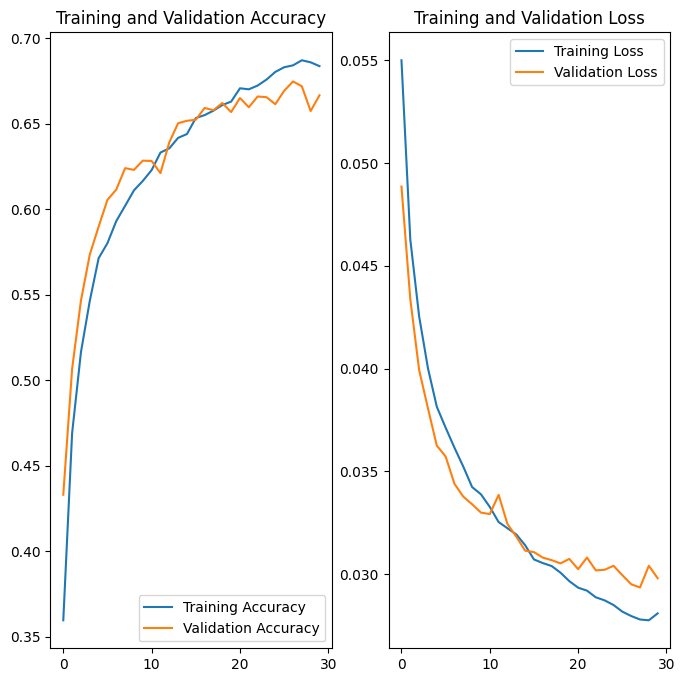

In [164]:
epochs_range = range(30)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [165]:
test_loop(test_dataloader, cnn_model, loss_fn)

---Test---
Accuracy: 0.6768
Total loss: 296.31999385356903


(296.31999385356903, 0.6768)

In [166]:
images, labels = next(iter(test_dataloader))

outputs = cnn_model(images.cuda())
preds = outputs.argmax(1)
print(preds)

tensor([3, 8, 0, 0, 6, 6, 1, 3, 3, 1, 0, 9, 5, 7, 9, 6, 5, 3, 8, 6, 7, 0, 4, 9,
        2, 3, 7, 0, 9, 6, 6, 2], device='cuda:0')


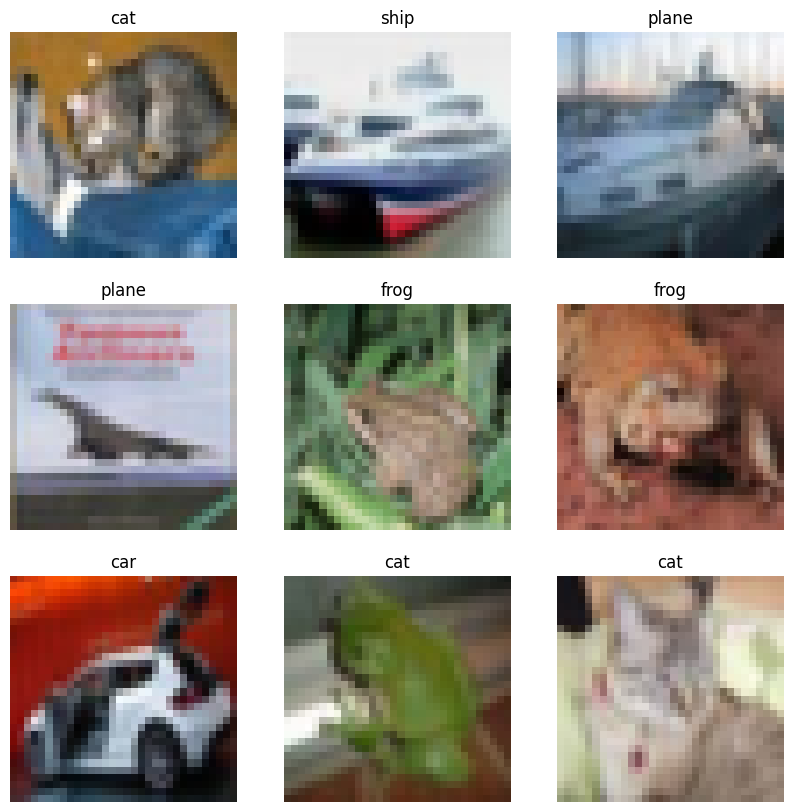

In [167]:
plt.figure(figsize=(10, 10))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  img = images[i]
  plt.imshow(img.permute(1, 2, 0))
  plt.title(classes[preds[i]])
  plt.axis("off")

## Finetuning pretrained models

In [34]:
from torchvision.models import efficientnet_v2_s, EfficientNet_V2_S_Weights

weights = EfficientNet_V2_S_Weights.DEFAULT
efficientnet_v2_model = efficientnet_v2_s(weights=weights)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

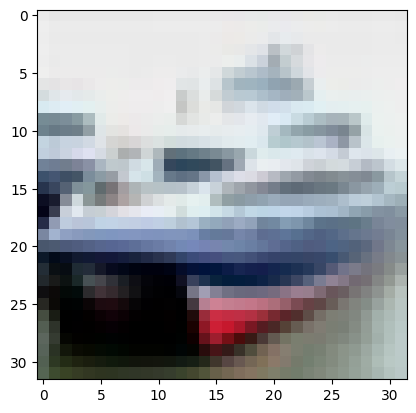

ship


In [24]:
images, labels = next(iter(test_dataloader))

test_image = images[1]
test_label = labels[1]
# print images
plt.imshow(test_image.permute(1, 2, 0))
print(classes[test_label])

In [35]:
preprocess = weights.transforms()

batch = preprocess(test_image).unsqueeze(0)

/usr/local/lib/python3.10/dist-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


In [36]:
print(batch.size())

torch.Size([1, 3, 224, 224])


In [37]:
prediction = efficientnet_v2_model(batch).squeeze(0).softmax(0)
class_id = prediction.argmax().item()
score = prediction[class_id].item()
category_name = weights.meta["categories"][class_id]
print(f"{category_name}: {100 * score:.1f}%")

wall clock: 99.5%


In [38]:
predictions = []
for i in range(len(images)):
  X = images[i]
  batch = preprocess(X).unsqueeze(0)
  prediction = efficientnet_v2_model(batch).squeeze(0).softmax(0)
  class_id = prediction.argmax().item()
  score = prediction[class_id].item()
  category_name = weights.meta["categories"][class_id]
  predictions.append(f"{category_name}: {100 * score:.1f}%")

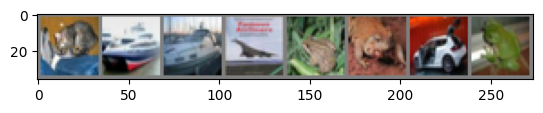

['chocolate sauce: 100.0%', 'wall clock: 99.5%', 'chocolate sauce: 100.0%', 'bubble: 100.0%', 'bow: 99.9%', 'chocolate sauce: 100.0%', 'bolo tie: 100.0%', 'bubble: 100.0%']


In [39]:
imshow(torchvision.utils.make_grid(images))
print(predictions)

## Finetune pretrained model on dataset

In [42]:
#change final layer
resnet_model.fc = nn.Linear(resnet_model.fc.in_features, len(classes))

In [45]:
from torchsummary import summary
summary(resnet_model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]           4,096
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
           Conv2d-11            [-1, 256, 8, 8]          16,384
      BatchNorm2d-12            [-1, 256, 8, 8]             512
           Conv2d-13            [-1, 256, 8, 8]          16,384
      BatchNorm2d-14            [-1, 25

In [43]:
resnet_model = resnet_model.to(device)

In [44]:
learning_rate = 1e-3
epochs = 10

# Initialize the loss function
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=learning_rate)

In [48]:
train_accuracy = []
test_accuracy = []
train_loss = []
test_loss = []
for i in range(epochs):
  print(f"Epoch {i+1}")
  train_loss_output, train_acc_output = train_loop(train_dataloader, resnet_model, loss_fn, optimizer)
  test_loss_output, test_acc_output = test_loop(test_dataloader, resnet_model, loss_fn)
  train_loss.append(train_loss_output)
  train_accuracy.append(train_acc_output)
  test_loss.append(test_loss_output)
  test_accuracy.append(test_acc_output)

Epoch 1
loss: 1.8752152  [  500/ 6250]
loss: 1.8990338  [ 1000/ 6250]
loss: 2.1716018  [ 1500/ 6250]
loss: 1.8428463  [ 2000/ 6250]
loss: 1.2353336  [ 2500/ 6250]
loss: 1.8948309  [ 3000/ 6250]
loss: 2.1299295  [ 3500/ 6250]
loss: 1.7887170  [ 4000/ 6250]
loss: 1.7928729  [ 4500/ 6250]
loss: 2.3365850  [ 5000/ 6250]
loss: 1.7313513  [ 5500/ 6250]
loss: 1.6709138  [ 6000/ 6250]
---Train---
Correct predictions: 14138.0
Accuracy: 0.28276
---Test---
Correct predictions: 2952.0
Accuracy: 0.2952
Total loss: 9008.271065711975
Epoch 2
loss: 2.1982217  [  500/ 6250]
loss: 1.4477592  [ 1000/ 6250]
loss: 2.4942095  [ 1500/ 6250]
loss: 1.8536105  [ 2000/ 6250]
loss: 1.2222733  [ 2500/ 6250]
loss: 1.8454471  [ 3000/ 6250]
loss: 1.9519665  [ 3500/ 6250]
loss: 1.3820748  [ 4000/ 6250]
loss: 1.6959827  [ 4500/ 6250]
loss: 2.0523427  [ 5000/ 6250]
loss: 1.6251589  [ 5500/ 6250]
loss: 1.8745723  [ 6000/ 6250]
---Train---
Correct predictions: 15832.0
Accuracy: 0.31664
---Test---
Correct predictions: 2866

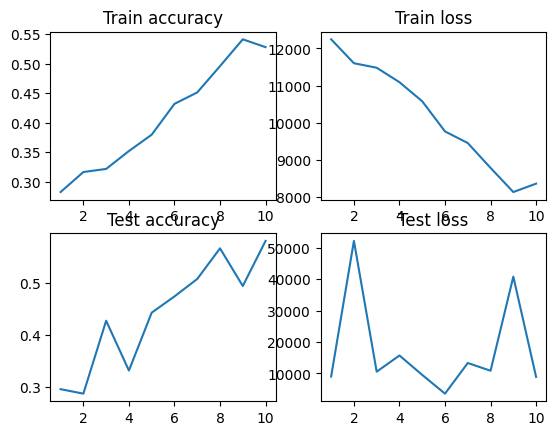

<Figure size 1500x1000 with 0 Axes>

In [49]:
fig, axs = plt.subplots(2, 2)
plt.figure(figsize=(15, 10))
indexes = [i for i in range(1, epochs+1)]
axs[0, 0].plot(indexes, train_accuracy)
axs[0, 0].set_title("Train accuracy")
axs[0, 1].plot(indexes, train_loss)
axs[0, 1].set_title("Train loss")
axs[1, 0].plot(indexes, test_accuracy)
axs[1, 0].set_title("Test accuracy")
axs[1, 1].plot(indexes, test_loss)
axs[1, 1].set_title("Test loss")
fig.show()

In [51]:
#save model
PATH = "resnet_model.pt"
torch.save(resnet_model.state_dict(), PATH)